In [1]:
from metro_utils import graph, Station
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

from itertools import permutations, chain, combinations

def distance(s1, s2):
    lΔxl = abs(s1.x - s2.x)
    lΔyl = abs(s1.y - s2.y)
    
    m = min(lΔxl, lΔyl)
    M = max(lΔxl, lΔyl)
    
    return M + (2**0.5 - 1) * m

def total_distance(rails):
    # Check if rails is just one rail
    if isinstance(rails[0], Station):
        rails = [rails]
        
    dist = 0
    for rail in rails:
        start = rail[0]
        for end in rail[1:]:
            dist += distance(start, end)
            start = end
            
    return dist

def brute_force_tsp(stations):
    max_dist = 1e12
    best = None

    for perm in permutations(stations):
        perm = list(perm)
        perm.append(perm[0])

        dist = total_distance(perm)
        if dist < max_dist:
            max_dist = dist
            best = perm
            
    return best

N = 10 # Stations

Station.reset()
stations = [Station() for _ in range(N)]

In [2]:
#best = brute_force_tsp(stations)
#total_distance(best)

# Stage 0
TSP

$$\begin{aligned}
&z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} x_{i j} \\
&\text { s.t. } \\
&\sum_{j=1}^{n} x_{i j}=1, \quad i \in I, \\
&\sum_{i=1}^{n} x_{i j}=1, \quad j \in I, \\
&\sum_{i \in S}\sum_{j \in S} x_{ij} \leq |S|-1, \qquad S \subset I, 2 \leq |S| \leq n-1, \\
&x_{i j} \in\{0,1\}, \quad i, j=1, \ldots, n.
\end{aligned}$$

In [3]:
from math import ceil

def subsets(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return [[s for s in sub] for sub in chain.from_iterable(combinations(s, r) for r in range(2, ceil((len(s)+1)/2) ))]

subs = subsets(stations)

dist = {(s1, s2): distance(s1, s2) for s1 in stations for s2 in stations}

In [4]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

x = m.addVars(N, N, vtype=GRB.INTEGER, name="x")

m.setObjective( gp.quicksum( dist[(s1, s2)]*x[s1.id, s2.id] for s1 in stations for s2 in stations if s1 != s2), GRB.MINIMIZE )

# leave each station only once
m.addConstrs( gp.quicksum(x[s1.id, s2.id] for s1 in stations if s1 != s2 ) == 1 for s2 in stations )
# enter each station only once
m.addConstrs( gp.quicksum(x[s1.id, s2.id] for s2 in stations if s1 != s2 ) == 1 for s1 in stations )
# Subtour elimination constraints
for sub in subs:
    m.addConstr( gp.quicksum(x[s1.id, s2.id] for s1 in sub for s2 in sub if s1 != s2) <= len(sub) - 1 )

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-18
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 647 rows, 100 columns and 8550 nonzeros
Model fingerprint: 0x9d04b251
Variable types: 0 continuous, 100 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-02, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 5.6214258
Presolve removed 0 rows and 10 columns
Presolve time: 0.02s
Presolved: 647 rows, 90 columns, 8550 nonzeros
Variable types: 0 continuous, 90 integer (90 binary)

Root relaxation: objective 2.912720e+00, 26 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               

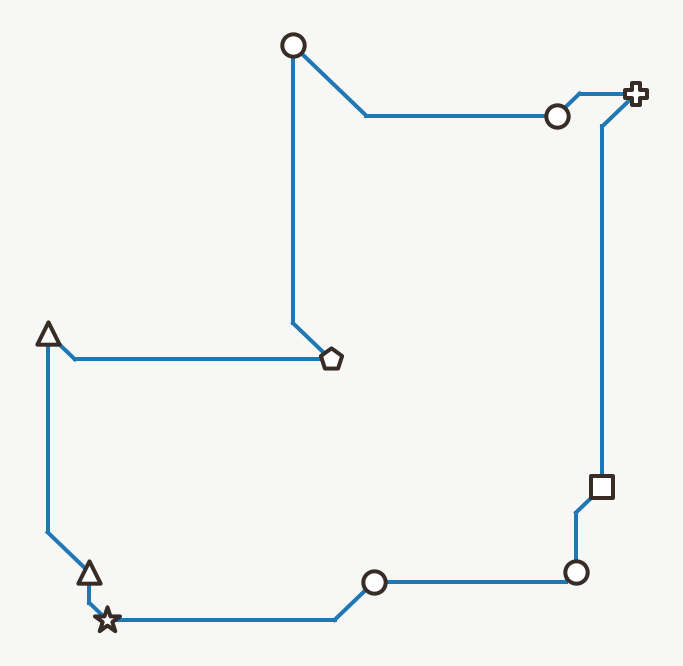

In [5]:
def extract_stations(var_name):
    ''' x[1, 2] -> (Station1, Station2)
        x[1, 2, 1] -> (Station1, Station2, Rail1)
    '''
    i, j = var_name.index('['), var_name.index(']')
    indexes = var_name[i+1: j].split(',')
    
    # If just two stations
    if len(indexes) == 2:
        return [Station.get_station(int(s)) for s in indexes]
    # Else 2 stations and rail
    return [Station.get_station(int(s)) for s in indexes[:2]] + [int(indexes[2])]
            
def pairs2rails(pairs):
    ''' [(1, 2), (2, 3)] -> [1, 2, 3]'''

    # Step 1. Check if there is an endpoint
    starts = [pair[0] for pair in pairs]
    ends   = [pair[1] for pair in pairs]

    for end in ends:
        if end not in starts:
            station = end
            break
    else:
        # We have a cycle so starting point is arbitrary
        station = starts[0]

    # Step 2. Work through list building up
    pairs = dict(pairs)
    rails = [station]

    while pairs:
        station = pairs.pop(station)
        rails.append(station)
        
    return rails

best = pairs2rails([extract_stations(v.varName) for v in m.getVars() if v.x > 1e-6])
graph(stations, best)

# Stage 1
MTSP

# This is Non-Linear

$$\begin{aligned}
&z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} x_{i j} y_{ij}\\
&\text { s.t. } \\
&\sum_{j=1}^{n} x_{i j} y_{ij}=1, \quad i \in I \\
&\sum_{i=1}^{n} x_{i j} y_{ij}=1, \quad j \in I \\
&2(y_{ij} + 1) = \sum_{k=1}^n x_{ki} + \sum_{k=1}^n x_{jk} , \quad i \in I, j \in J\\
&\sum_{i=1}^n\sum_{j=1}^n y_{ij} \leq m, \quad j \in J\\
&x_{i j} \in\{0,1\}, \quad i, j=1, \ldots, n.
\end{aligned}$$


# This is Linear

$$\begin{aligned}
&z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} (x_{i j} - y_{ij}) \\
&\text { s.t. } \\
&\sum_{j=1}^{n} x_{i j} - y_{ij}=1, \quad i \in I \\
&\sum_{i=1}^{n} x_{i j} - y_{ij}=1, \quad j \in I \\
&2(y_{ij} + 1) = \sum_{k=1}^n x_{ki} + \sum_{k=1}^n x_{jk} , \quad i \in I, j \in J\\
&\sum_{i=1}^n\sum_{j=1}^n y_{ij} \leq m, \quad j \in J\\
&x_{i j} \in\{0,1\}, \quad i, j=1, \ldots, n.
\end{aligned}$$

In [74]:
import gurobipy as gp
from gurobipy import GRB

M = 2
D = [s.id for s in stations[:M]]
V = [s.id for s in stations[M:]]
K = 3
L = N - (M-1)*K
mk = 1 # Num trains from kth depot

c = {(s1.id, s2.id): distance(s1, s2) for s1 in stations for s2 in stations}

m = gp.Model()

x = m.addVars(N, N, M, vtype=GRB.INTEGER, name="x")
u = m.addVars(N, vtype=GRB.INTEGER, name="u")

m.setObjective(gp.quicksum( c[(k, j)]*x[k, j, k] + c[(j, k)]*x[j, k, k] for k in D for j in V) +
               gp.quicksum( c[(i, j)]*x[i, j, k] for k in D for j in V for i in V), GRB.MINIMIZE)

# 2
m.addConstrs(gp.quicksum(x[k, j, k] for j in V) == mk for k in D)
# 3
m.addConstrs(gp.quicksum(x[k, j, k] for k in D) + gp.quicksum(x[i, j, k] for k in D for i in V) == 1 for j in V)
# 4
m.addConstrs(x[k, j, k] + gp.quicksum(x[i, j, k] for i in V) - x[j, k, k] - 
             gp.quicksum(x[j, i, k] for i in V) == 0 for k in D for j in V)
# 5
m.addConstrs(gp.quicksum(x[k, j, k] for j in V) - gp.quicksum(x[j, k, k] for j in V) == 0 for k in D)
# 6
m.addConstrs(u[i] + (L - 2)*gp.quicksum(x[k, i, k] for k in D) - 
             gp.quicksum(x[i, k, k] for k in D) <= L - 1 for i in V)
# 7
m.addConstrs(u[i] + gp.quicksum(x[k, i, k] for k in D) + (2 - K)*gp.quicksum(x[i, k, k] for k in D) >= 2 for i in V)
# 8
m.addConstrs(gp.quicksum(x[k, i, k] for k in D) + gp.quicksum(x[i, k, k] for k in D) <= 1 for i in V)
# 9
m.addConstrs(u[i] - u[j] + L*gp.quicksum(x[i, j, k] for k in D) + 
             (L - 2)*gp.quicksum(x[j, i, k] for k in D) <= L - 1 for i in V for j in V if i != j)
# 10
m.addConstrs(x[i, i, k] == 0 for i in V for k in D)

m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 124 rows, 210 columns and 912 nonzeros
Model fingerprint: 0x60563a92
Variable types: 0 continuous, 210 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [7e-02, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 16 rows and 58 columns
Presolve time: 0.01s
Presolved: 108 rows, 152 columns, 864 nonzeros
Variable types: 0 continuous, 152 integer (144 binary)
Found heuristic solution: objective 5.9450356

Root relaxation: objective 2.812917e+00, 55 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.81292    0   13    5.94504    2.81292  52.7%     -    0s
H    0     0                       5.3118

In [75]:
for var in m.getVars():
    if var.x > 1e-6:
        print(var.varName, var.x)

x[0,3,0] 1.0
x[1,6,1] 1.0
x[2,1,1] 1.0
x[3,7,0] 1.0
x[4,2,1] 1.0
x[5,0,0] 1.000000383990385
x[6,4,1] 1.0
x[7,8,0] 1.0000003840049014
x[8,9,0] 1.0
x[9,5,0] 1.0
u[2] 3.0
u[3] 1.0
u[4] 2.0
u[5] 5.000000767564102
u[6] 1.0
u[7] 2.0000026875886094
u[8] 3.000000769230769
u[9] 4.000000767564103


In [76]:
from collections import defaultdict as dd

RAIL = 2

connections = [extract_stations(v.varName) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x']

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL]].append(connection[:2])
    
rail_pairs

defaultdict(list,
            {0: [[0, 3], [3, 7], [5, 0], [7, 8], [8, 9], [9, 5]],
             1: [[1, 6], [2, 1], [4, 2], [6, 4]]})

In [77]:
def pairs2rails(pairs):
    ''' [(1, 2), (2, 3)] -> [1, 2, 3]'''

    # Step 1. Check if there is an endpoint
    starts = [pair[0] for pair in pairs]
    ends   = [pair[1] for pair in pairs]

    for end in ends:
        if end not in starts:
            station = end
            break
    else:
        # We have a cycle so starting point is arbitrary
        station = starts[0]

    # Step 2. Work through list building up
    pairs = dict(pairs)
    rails = [station]

    while pairs:
        print(pairs, station)
        station = pairs.pop(station)
        rails.append(station)
        
    return rails

In [78]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs))
    
rails

{0: 3, 3: 7, 5: 0, 7: 8, 8: 9, 9: 5} 0
{3: 7, 5: 0, 7: 8, 8: 9, 9: 5} 3
{5: 0, 7: 8, 8: 9, 9: 5} 7
{5: 0, 8: 9, 9: 5} 8
{5: 0, 9: 5} 9
{5: 0} 5
{1: 6, 2: 1, 4: 2, 6: 4} 1
{2: 1, 4: 2, 6: 4} 6
{2: 1, 4: 2} 4
{2: 1} 2


[[0, 3, 7, 8, 9, 5, 0], [1, 6, 4, 2, 1]]

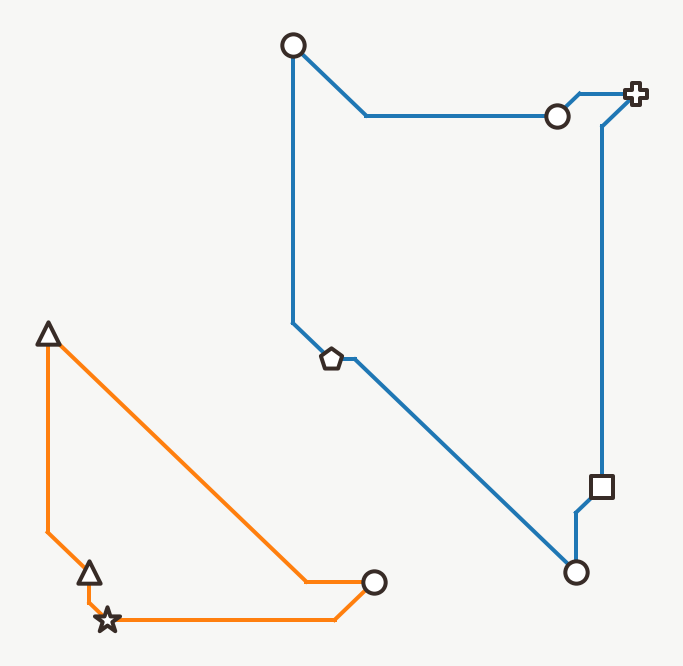

In [79]:
graph(stations, rails)